In [1]:
import pandas as pd
import requests
import io
from bs4 import BeautifulSoup 
import re
import glob
import numpy as np
import pint
from pint import UnitRegistry
ureg=pint.UnitRegistry()

import gppd_co2 as gp

Using TensorFlow backend.


## Available datasets 

The following function returns a list of csvs of available emissions datasests for Australia. 

In [2]:
AUS_URL = 'http://www.cleanenergyregulator.gov.au/NGER/National%20greenhouse%20and%20energy%20reporting%20data/electricity-sector-emissions-and-generation-data'

def available_datasets(source_URL):
    r = requests.get(source_URL) 
    print(r)
    soup = BeautifulSoup(r.text,'html.parser') 
    #removing superfluous links from the box at the bottom of the website
    last_links=soup.find(class_='box')
    last_links.decompose()
    
    #pulling all text from the cer-contentPage-innerContent div and all instances of <a> tag within it
    elect_sector_items= soup.find(class_='cer-contentPage-innerContent').find_all('a')
    
    #for loop to create a list of links to available datasets
    emission_datasets_links=[]
    for item in elect_sector_items:
        links= 'http://www.cleanenergyregulator.gov.au'+item.get('href')
        #keeping only links to emissions datasets
        if links[-4:]=='aspx':
            emission_datasets_links.append(links)
    
    #getting each dataset's csv file url
    
    soups=[]
    for link in emission_datasets_links:
        server_response= requests.get(link)
        print(server_response)
        soup_1=BeautifulSoup(server_response.text,'html.parser')
        soups.append(soup_1)
    
    co2_datasets=[]
    for soup_unique in soups:
        #pulling all text from the cer-contentPage-innerContent-wrapper div and all instances of <a> tag within it
        data_links = soup_unique.find('div', class_='cer-contentPage-innerContent-wrapper').find_all('a')
        #getting a list of available datasets 
        data_available=[]
        for url in data_links:
            links= 'http://www.cleanenergyregulator.gov.au'+url.get('href')
            if links[-4:]=='aspx':
                data_available.append(links)
        co2_datasets.append(data_available[-1])

    sub_soups=[]
    for ds in co2_datasets:
        sr= requests.get(ds)
        print(sr)
        soup_2=BeautifulSoup(sr.text,'html.parser')
        sub_soups.append(soup_2)
    
    csv_datasets=[]
    for soup_ind in sub_soups:
        #pulling all text from the documentAsset-outer div and all instances of <a> tag within it
        dl=soup_ind.find('div', class_='documentAsset-outer').find_all('a')
        links_available=[]
        for l_ind in dl:
            urls= l_ind.get('href')
            if urls[-3:]=='csv':
                links_available.append(urls)
        csv_datasets.append(links_available[0])
    
    return csv_datasets

In [3]:
aus_dat= available_datasets(AUS_URL)
aus_co2_dat= aus_dat
aus_co2_dat

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


['http://www.cleanenergyregulator.gov.au/DocumentAssets/Documents/Greenhouse and energy information for designated generation facilities 2017-18.csv',
 'http://www.cleanenergyregulator.gov.au/DocumentAssets/Documents/Greenhouse and energy information for designated generation facilities 2016-17.csv',
 'http://www.cleanenergyregulator.gov.au/DocumentAssets/Documents/Greenhouse and energy information for designated generation facilities 2015-16.csv',
 'http://www.cleanenergyregulator.gov.au/DocumentAssets/Documents/2014-15 Greenhouse and energy information for designated generation facilities.csv',
 'http://www.cleanenergyregulator.gov.au/DocumentAssets/Documents/2013-14 Greenhouse and energy information for designated generation facilities.csv',
 'http://www.cleanenergyregulator.gov.au/DocumentAssets/Documents/2012-13 Greenhouse and energy information for designated generation facilities.csv']

**There are currently 6 available datasets (2017-2018, 2016-2017, 2015-2016, 2014-2015, 2013-2014, 2012-13)**

## Saving raw CSV files

Getting a list of years covered in available datasets

In [4]:
dat_years=[]
for dataset in aus_co2_dat:
    year=re.search("\d{4}-\d{2}", dataset)
    dat_years.append(year.group())
dat_years    

['2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13']

Saving raw csv files in raw directory

In [5]:
for csv, year in zip(aus_co2_dat,dat_years):
        dat=requests.get(csv).content
        dataset=pd.read_csv(io.StringIO(dat.decode('cp1252')))
        dataset.to_csv('../public/raw/raw_australia_{}.csv'.format(year), index=False)

Checking that the files have been successfully saved 

In [6]:
aus_files = (glob.glob("../public/raw/raw_australia*.csv"))
aus_files

['../public/raw/raw_australia_2014-15.csv',
 '../public/raw/raw_australia_2017-18.csv',
 '../public/raw/raw_australia_2012-13.csv',
 '../public/raw/raw_australia_2015-16.csv',
 '../public/raw/raw_australia_2016-17.csv',
 '../public/raw/raw_australia_2013-14.csv']

## Reading raw CSV files

Creating a dictionary of available datasets for Australia with year as key

In [7]:
aus_datasets= {i:pd.read_csv('../public/raw/raw_australia_{}.csv'.format(i)) for i in dat_years}

## Data Cleaning

### Checking column names

In [8]:
for year,ds in aus_datasets.items():
    print(list(aus_datasets[year]))

['Reporting Entity', 'Facility Name', 'Type', 'State', 'Electricity Production (GJ)', 'Electricity Production (MWh)', 'Total Scope 1 Emissions \n(t CO2-e)', 'Total Scope 2 Emissions \n(t CO2-e)', 'Total Emissions \n(t CO2-e)', 'Emission Intensity \n(t CO2-e/ MWh)', 'Grid Connected', 'Grid', 'Primary Fuel', 'Important Notes']
['Reporting Entity', 'Facility Name', 'Type', 'State', 'Electricity Production (GJ)', 'Electricity Production (Mwh)', 'Total Scope 1 Emissions (t CO2-e)', 'Total Scope 2 Emissions (t CO2-e)2', 'Total Emissions (t CO2-e)', 'Emission Intensity (t/Mwh)', 'Grid Connected2', 'Grid', 'Primary Fuel', 'Important Notes']
['Controlling corporation', 'Facility Name', 'Type', 'State', 'Electricity Production (GJ)', 'Electricity Production (Mwh)', 'Total Scope 1 Emissions (t CO2-e)', 'Total Scope 2 Emissions (t CO2-e)', 'Total Emissions (t CO2-e)', 'Emission Intensity (t/Mwh)', 'Grid Connected', 'Grid', 'Primary Fuel', 'Important Notes']
['Reporting Entity ', 'Facility Name', '

### Adding a column for original index numbers

This will be used later for matching with GPPD since the power plants don't have a unique ID and the indeces will change as we drop corporate total rows, duplicate rows, etc. 

In [9]:
for year,ds in aus_datasets.items():
    aus_datasets[year]['nger_{}_index'.format(year)]=aus_datasets[year].index

### Inspecting 'Types'

In [10]:
for year,ds in aus_datasets.items():
     print(aus_datasets[year].groupby('Type').count())

      Reporting Entity  Facility Name  State  Electricity Production (GJ)  \
Type                                                                        
C                   97             97     97                           97   
F                  425            425    425                          425   

      Electricity Production (MWh)  Total Scope 1 Emissions \n(t CO2-e)  \
Type                                                                      
C                               97                                   97   
F                              425                                  425   

      Total Scope 2 Emissions \n(t CO2-e)  Total Emissions \n(t CO2-e)  \
Type                                                                     
C                                      97                           97   
F                                     425                          425   

      Emission Intensity \n(t CO2-e/ MWh)  Grid Connected  Grid  Primary Fuel  \
Type        

### Dropping 'Types' != F or FA

In [11]:
for year,ds in aus_datasets.items():
    aus_datasets[year]['Type'].replace(['FA'], ['F'], inplace=True)
    aus_datasets[year].drop(aus_datasets[year].loc[aus_datasets[year]['Type']!='F'].index, inplace=True)

### Standardizing columns and removing unwanted ones

In [12]:
for year, ds in aus_datasets.items():
    aus_datasets[year].drop(aus_datasets[year].columns[0], axis=1, inplace=True)
    aus_datasets[year].rename(columns={'Total Scope 2 Emissions (t CO2-e)2': 'Total Scope 2 Emissions (t CO2-e)'}, inplace=True)
    aus_datasets[year].rename(columns={'Greenhouse Gas Emissions Scope 2 (t-CO2-e)': 'Greenhouse Gas Emissions Scope 2 (t CO2-e)'}, inplace=True)
    aus_datasets[year].rename(columns={'Greenhouse Gas Emissions Scope 1 (t-CO2-e)': 'Greenhouse Gas Emissions Scope 1 (t CO2-e)'}, inplace=True)
    aus_datasets[year].columns = aus_datasets[year].columns.str.replace('Emissions', '')
    aus_datasets[year].columns = aus_datasets[year].columns.str.replace('.*Scope 1', 'Scope 1 Emissions')
    aus_datasets[year].columns = aus_datasets[year].columns.str.replace('.*Scope 2', 'Scope 2 Emissions')
    aus_datasets[year].columns = aus_datasets[year].columns.str.replace('\n','')
    aus_datasets[year].columns = aus_datasets[year].columns.str.replace('  ',' ')
    aus_datasets[year].columns = aus_datasets[year].columns.str.replace('.*(t/Mwh)', 'Emission Intensity (t CO2-e/MWh')
    aus_datasets[year].columns = aus_datasets[year].columns.str.replace('.*(t CO2-e/ MWh)', 'Emission Intensity (t CO2-e/MWh')
    aus_datasets[year].columns = aus_datasets[year].columns.str.replace('.*(Mwh)', 'Electricity Production (MWh')
    aus_datasets[year].replace({'-': np.nan}, inplace=True)
    aus_datasets[year].drop(list(aus_datasets[year].filter(regex = 'Total')), axis = 1, inplace = True)
    aus_datasets[year].drop(list(aus_datasets[year].filter(regex = 'Type')), axis = 1, inplace = True)
    aus_datasets[year].drop(list(aus_datasets[year].filter(regex = 'Grid')), axis = 1, inplace = True)
    aus_datasets[year].drop(list(aus_datasets[year].filter(regex = 'Important')), axis = 1, inplace = True)
    aus_datasets[year].drop(list(aus_datasets[year].filter(regex = 'State')), axis = 1, inplace = True)

In [13]:
for year,ds in aus_datasets.items():
    print(list(aus_datasets[year]))

['Facility Name', 'Electricity Production (GJ)', 'Electricity Production (MWh)', 'Scope 1 Emissions (t CO2-e)', 'Scope 2 Emissions (t CO2-e)', 'Emission Intensity (t CO2-e/MWh)', 'Primary Fuel', 'nger_2017-18_index']
['Facility Name', 'Electricity Production (GJ)', 'Electricity Production (MWh)', 'Scope 1 Emissions (t CO2-e)', 'Scope 2 Emissions (t CO2-e)', 'Emission Intensity (t CO2-e/MWh)', 'Primary Fuel', 'nger_2016-17_index']
['Facility Name', 'Electricity Production (GJ)', 'Electricity Production (MWh)', 'Scope 1 Emissions (t CO2-e)', 'Scope 2 Emissions (t CO2-e)', 'Emission Intensity (t CO2-e/MWh)', 'Primary Fuel', 'nger_2015-16_index']
['Facility Name', 'Electricity Production (GJ)', 'Electricity Production (MWh)', 'Scope 1 Emissions (t CO2-e)', 'Scope 2 Emissions (t CO2-e)', 'Emission Intensity (t CO2-e/MWh)', 'Primary Fuel', 'nger_2014-15_index']
['Facility Name', 'Electricity Production (GJ)', 'Scope 1 Emissions (t CO2-e)', 'Scope 2 Emissions (t CO2-e)', 'nger_2013-14_index']

### Removing comma from strings and converting to integers or floats 

In [14]:
for year, ds in aus_datasets.items():
    if 'Electricity Production (GJ)' in aus_datasets[year].columns:
        aus_datasets[year].loc[aus_datasets[year]['Electricity Production (GJ)'].notnull(),'Electricity Production (GJ)']=aus_datasets[year].loc[aus_datasets[year]['Electricity Production (GJ)'].notnull(),'Electricity Production (GJ)'].astype(str).str.replace(",","").astype(float).astype(int)
        aus_datasets[year]['Electricity Production (GJ)']=aus_datasets[year]['Electricity Production (GJ)'].astype(pd.Int64Dtype())
    else:
        pass
    if 'Electricity Production (MWh)' in aus_datasets[year].columns:
        aus_datasets[year].loc[aus_datasets[year]['Electricity Production (MWh)'].notnull(),'Electricity Production (MWh)']=aus_datasets[year].loc[aus_datasets[year]['Electricity Production (MWh)'].notnull(),'Electricity Production (MWh)'].astype(str).str.replace(",","").astype(float).astype(int)
        aus_datasets[year]['Electricity Production (MWh)']=aus_datasets[year]['Electricity Production (MWh)'].astype(pd.Int64Dtype())
    else:
        pass
    if 'Scope 1 Emissions (t CO2-e)' in aus_datasets[year].columns:
        aus_datasets[year].loc[aus_datasets[year]['Scope 1 Emissions (t CO2-e)'].notnull(),'Scope 1 Emissions (t CO2-e)']=aus_datasets[year].loc[aus_datasets[year]['Scope 1 Emissions (t CO2-e)'].notnull(),'Scope 1 Emissions (t CO2-e)'].astype(str).str.replace(",","").astype(int)
        aus_datasets[year]['Scope 1 Emissions (t CO2-e)']=aus_datasets[year]['Scope 1 Emissions (t CO2-e)'].astype(pd.Int64Dtype())
    else:
        pass
    if 'Scope 2 Emissions (t CO2-e)' in aus_datasets[year].columns:
        aus_datasets[year].loc[aus_datasets[year]['Scope 2 Emissions (t CO2-e)'].notnull(),'Scope 2 Emissions (t CO2-e)']=aus_datasets[year].loc[aus_datasets[year]['Scope 2 Emissions (t CO2-e)'].notnull(),'Scope 2 Emissions (t CO2-e)'].astype(str).str.replace(",","").astype(int)
        aus_datasets[year]['Scope 2 Emissions (t CO2-e)']=aus_datasets[year]['Scope 2 Emissions (t CO2-e)'].astype(pd.Int64Dtype())
    else:
        pass
    if 'Emission Intensity (t CO2-e/ MWh)' in aus_datasets[year].columns:
        aus_datasets[year].loc[aus_datasets[year]['Emission Intensity (t CO2-e/ MWh)'].notnull(),'Emission Intensity (t CO2-e/ MWh)']=aus_datasets[year].loc[aus_datasets[year]['Emission Intensity (t CO2-e/ MWh)'].notnull(),'Emission Intensity (t CO2-e/ MWh)'].astype(float)
        aus_datasets[year]['Emission Intensity (t CO2-e/ MWh)']=aus_datasets[year]['Emission Intensity (t CO2-e/ MWh)'].astype(float)
    else:
        pass
           

In [15]:
for year,ds in aus_datasets.items():
    print(aus_datasets[year].dtypes)

Facility Name                       object
Electricity Production (GJ)          Int64
Electricity Production (MWh)         Int64
Scope 1 Emissions (t CO2-e)          Int64
Scope 2 Emissions (t CO2-e)          Int64
Emission Intensity (t CO2-e/MWh)    object
Primary Fuel                        object
nger_2017-18_index                   int64
dtype: object
Facility Name                       object
Electricity Production (GJ)          Int64
Electricity Production (MWh)         Int64
Scope 1 Emissions (t CO2-e)          Int64
Scope 2 Emissions (t CO2-e)          Int64
Emission Intensity (t CO2-e/MWh)    object
Primary Fuel                        object
nger_2016-17_index                   int64
dtype: object
Facility Name                        object
Electricity Production (GJ)           Int64
Electricity Production (MWh)          Int64
Scope 1 Emissions (t CO2-e)           Int64
Scope 2 Emissions (t CO2-e)           Int64
Emission Intensity (t CO2-e/MWh)    float64
Primary Fuel        

### Dropping duplicates

Dropping duplicate rows and keeping first occurance

In [16]:
for year,ds in aus_datasets.items():
    aus_datasets[year].drop_duplicates(subset=['Facility Name','Scope 1 Emissions (t CO2-e)',
                                                'Scope 2 Emissions (t CO2-e)'], keep='first', inplace=True)

### Grouping multiple entries per facility

In [17]:
for year,ds in aus_datasets.items():
    print(aus_datasets[year][aus_datasets[year]['Facility Name'].isin(aus_datasets[year]['Facility Name'][aus_datasets[year]['Facility Name'].duplicated()])].sort_values(by=['Facility Name']))

             Facility Name  Electricity Production (GJ)  \
203  Solomon Power Station                       666413   
512  Solomon Power Station                       334016   
191     Waterloo Wind Farm                       329504   
344     Waterloo Wind Farm                      1103275   

     Electricity Production (MWh)  Scope 1 Emissions (t CO2-e)  \
203                        185115                       115169   
512                         92782                        58143   
191                         91529                            6   
344                        306465                           97   

     Scope 2 Emissions (t CO2-e) Emission Intensity (t CO2-e/MWh)  \
203                            0                             0.62   
512                            0                             0.63   
191                           29                             0.00   
344                          173                             0.00   

    Primary Fuel  nger_2017

In [18]:
for year,ds in aus_datasets.items():
    if 'Electricity Production (MWh)' in aus_datasets[year].columns:
        aus_datasets[year]=aus_datasets[year].groupby('Facility Name', as_index=False).agg({'Electricity Production (GJ)':'sum',
                                                                                       'Electricity Production (MWh)': 'sum',
                                                                                       'Scope 1 Emissions (t CO2-e)': 'sum',
                                                                                       'Scope 2 Emissions (t CO2-e)':'sum',
                                                                                       'Emission Intensity (t CO2-e/MWh)': 'min',
                                                                                       'Primary Fuel': 'min',
                                                                                       'nger_{}_index'.format(year):'min'})
    else:
        aus_datasets[year]=aus_datasets[year].groupby('Facility Name', as_index=False).agg({'Electricity Production (GJ)':'sum',
                                                                                       'Scope 1 Emissions (t CO2-e)': 'sum',
                                                                                       'Scope 2 Emissions (t CO2-e)':'sum',
                                                                                       'nger_{}_index'.format(year):'min'})
    

## Saving 'in_process' CSV files

In [19]:
for year,ds in aus_datasets.items():
    aus_datasets[year].to_csv('../public/in_process/in_process_australia_{}.csv'.format(year), index=False)

Checking that the files have been successfully saved

In [20]:
aus_ip_files = (glob.glob("../public/in_process/in_process_australia*.csv"))
aus_ip_files

['../public/in_process/in_process_australia_2012-13.csv',
 '../public/in_process/in_process_australia_2017-18.csv',
 '../public/in_process/in_process_australia_2014-15.csv',
 '../public/in_process/in_process_australia_2015-16.csv',
 '../public/in_process/in_process_australia_2016-17.csv',
 '../public/in_process/in_process_australia_2013-14.csv']

## Reading  'in_process' CSV files

Creating a dictionary of datasets with year as key

In [21]:
aus_ip_ds= {i:pd.read_csv('../public/in_process/in_process_australia_{}.csv'.format(i)) for i in dat_years}

## Formatting datasets for analysis

### Formatting column names to lower case separated by '_'

In [22]:
for year,ds in aus_ip_ds.items():
    aus_ip_ds[year].columns = aus_ip_ds[year].columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

### Dropping unwanted columns

In [23]:
for year,ds in aus_ip_ds.items():
    if 'electricity_production_mwh' in aus_ip_ds[year].columns:
        aus_ip_ds[year].drop(['scope_2_emissions_t_co2-e', 'emission_intensity_t_co2-e/mwh'], axis=1, inplace=True)
    else:
        aus_ip_ds[year].drop(['scope_2_emissions_t_co2-e'], axis=1, inplace=True)        

### Adding CO2 storage fields 

In [24]:
source_year=dict(zip(dat_years,aus_co2_dat))

Adding country, year, data_source_id, emission_species, emission_accounting scope

In [25]:
for year,ds in aus_ip_ds.items():
    aus_ip_ds[year]['country']= 'AUS'
    aus_ip_ds[year]['year']="{}".format(year)
    aus_ip_ds[year]['emmission_data_source']=aus_ip_ds[year]['year'].map(source_year)
    aus_ip_ds[year]['emission_species']= 1
    aus_ip_ds[year]['emission_accounting_scope']= 1
    aus_ip_ds[year].rename(columns={'facility_name':'name','electricity_production_gj':'generation_GJ','electricity_production_mwh':'generation_MWh','scope_1_emissions_t_co2-e': 'co2_emissions_tonne'}, inplace=True)

### Adding plant ID

**Note:** If matching csv is updated, it can be retrieved from Github at https://raw.githubusercontent.com/wri/global-power-plant-database/master/resources/AUS/AUS_plants.csv 

In [26]:
aus_id=pd.read_csv('AUS_plants.csv')

#if data for additional years is retrieved, will have to change the name of the nger_index column manually below:

aus_id.rename(columns={'nger_2012-2013_index': 'nger_2012-13_index',
                      'nger_2013-2014_index': 'nger_2013-14_index',
                      'nger_2014-2015_index': 'nger_2014-15_index',
                      'nger_2015-2016_index': 'nger_2015-16_index',
                      'nger_2016-2017_index': 'nger_2016-17_index',
                      'nger_2017-2018_index': 'nger_2017-18_index'}, inplace=True)

aus_id.dropna(subset=['gppd_idnr'], inplace=True)


for year,ds in aus_ip_ds.items():
    aus_id['nger_{}_index'.format(year)] = aus_id['nger_{}_index'.format(year)].astype(str).str.split('&').str[0].str.strip()
    aus_id['nger_{}_index'.format(year)].replace({'nan': np.nan}, inplace=True)


In [27]:
for year,ds in aus_ip_ds.items():
    aus_ip_ds[year]=pd.merge(aus_ip_ds[year],aus_id[['nger_{}_index'.format(year),'gppd_idnr']],on='nger_{}_index'.format(year), how='left')

Dropping nger index column

In [28]:
for year,ds in aus_ip_ds.items():
    aus_ip_ds[year].drop(['nger_{}_index'.format(year)], axis=1, inplace=True)  

### Unit conversions

Checking that conversion from GJ to GWh and from MWh to GWh produce the same output

In [29]:
aus_ip_ds['2017-18'].head(1)

,name,generation_GJ,generation_MWh,co2_emissions_tonne,primary_fuel,country,year,emmission_data_source,emission_species,emission_accounting_scope,gppd_idnr
0,Albany Wind Farm,333656,92682,12,Wind,AUS,2017-18,http://www.cleanenergyregulator.gov.au/Documen...,1,1,AUS0000065


In [30]:
generation_gj= 333656*ureg.GJ
print(generation_gj)
generation_gwh = generation_gj.to(ureg.GWh)
print(generation_gwh)

generation_mwh= 92682*ureg.MWh
print(generation_mwh)
generation_gwh_1 = generation_mwh.to(ureg.GWh)
print(generation_gwh_1)

333656 gigajoule
92.68222222222222 gigawatt_hour
92682 megawatt_hour
92.68200000000002 gigawatt_hour


Dropping Generation MWh

In [31]:
for year,ds in aus_ip_ds.items():
    if 'generation_MWh' in aus_ip_ds[year].columns:
        aus_ip_ds[year].drop(['generation_MWh'], axis=1, inplace=True)
    else:
        pass

Using pint to specify GJ units and then convert to GWh

In [32]:
for year,ds in aus_ip_ds.items():
    aus_ip_ds[year]['generation_GJ'] = aus_ip_ds[year]['generation_GJ'].apply(lambda x: x*ureg.GJ)
    aus_ip_ds[year]['generation_GJ'] = aus_ip_ds[year]['generation_GJ'].apply(lambda x: x.to(ureg.GWh))
    aus_ip_ds[year]['generation_GJ'] = aus_ip_ds[year]['generation_GJ'].apply(lambda x: x.magnitude)
    aus_ip_ds[year].rename(columns={'generation_GJ':'generation_gwh'}, inplace=True)
    
aus_ip_ds['2017-18'].head(1)

,name,generation_gwh,co2_emissions_tonne,primary_fuel,country,year,emmission_data_source,emission_species,emission_accounting_scope,gppd_idnr
0,Albany Wind Farm,92.682222,12,Wind,AUS,2017-18,http://www.cleanenergyregulator.gov.au/Documen...,1,1,AUS0000065


### Changing year to match GPPD

Example: australia 17-18 maps to 2018

In [33]:
for year,ds in aus_ip_ds.items():
    aus_ip_ds[year]['year'] = aus_ip_ds[year]['year'].apply(lambda x: '20'+x[-2:])

aus_ip_ds['2017-18'].head(1)

,name,generation_gwh,co2_emissions_tonne,primary_fuel,country,year,emmission_data_source,emission_species,emission_accounting_scope,gppd_idnr
0,Albany Wind Farm,92.682222,12,Wind,AUS,2018,http://www.cleanenergyregulator.gov.au/Documen...,1,1,AUS0000065


### Adding features from GPPD

Retrieving the latest version of GPPD

In [34]:
gppd= pd.read_csv('../public/gppd/gppd.csv')
list(gppd)

['country',
 'country_long',
 'name',
 'gppd_idnr',
 'capacity_mw',
 'latitude',
 'longitude',
 'primary_fuel',
 'other_fuel1',
 'other_fuel2',
 'other_fuel3',
 'commissioning_year',
 'owner',
 'source',
 'url',
 'geolocation_source',
 'wepp_id',
 'year_of_capacity_data',
 'generation_gwh_2013',
 'generation_gwh_2014',
 'generation_gwh_2015',
 'generation_gwh_2016',
 'generation_gwh_2017',
 'estimated_generation_gwh']

Specifying primary_fuel_nger and then merging desired columns from GPPD

In [35]:
for year,ds in aus_ip_ds.items():
    if 'primary_fuel' in aus_ip_ds[year].columns:
        aus_ip_ds[year].rename(columns={'primary_fuel':'primary_fuel_nger'}, inplace=True)
    else:
        pass

In [36]:
for year,ds in aus_ip_ds.items():
    aus_ip_ds[year] = pd.merge(aus_ip_ds[year],gppd[['gppd_idnr','capacity_mw', 'latitude',
                     'longitude', 'primary_fuel','commissioning_year']],on='gppd_idnr', how='left')

In [37]:
for year,ds in aus_ip_ds.items():
    aus_ip_ds[year]['plant_type'] = np.nan
    aus_ip_ds[year]['unit_count'] = np.nan

### Changing order of columns in dataframes

In [38]:
for year,ds in aus_ip_ds.items():
    if 'primary_fuel_nger' in aus_ip_ds[year].columns:
        aus_ip_ds[year]= aus_ip_ds[year][['name','gppd_idnr','country', 'year', 'emmission_data_source', 
                                          'co2_emissions_tonne', 'emission_species','emission_accounting_scope', 
                                          'capacity_mw','primary_fuel', 'primary_fuel_nger', 'generation_gwh',
                                          'commissioning_year','latitude', 'longitude',
                                         'plant_type', 'unit_count']]
    else:
        aus_ip_ds[year]= aus_ip_ds[year][['name','gppd_idnr','country', 'year', 'emmission_data_source', 
                                          'co2_emissions_tonne', 'emission_species','emission_accounting_scope', 
                                          'capacity_mw','primary_fuel', 'generation_gwh','commissioning_year',
                                          'latitude', 'longitude', 'plant_type', 'unit_count']]  

### Encoding primary_fuel

In [39]:
for year,ds in aus_ip_ds.items():
    if 'primary_fuel_nger' in aus_ip_ds[year].columns:
        aus_ip_ds[year].drop(['primary_fuel'], axis=1, inplace=True)
        aus_ip_ds[year].rename(columns={'primary_fuel_nger': 'fuel'}, inplace=True)
        gp.class_coding.map_fuel_codes(aus_ip_ds[year], 'fuel')
        aus_ip_ds[year].rename(columns={'fuel': 'primary_fuel'}, inplace=True)
    else:
        aus_ip_ds[year].rename(columns={'primary_fuel': 'fuel'}, inplace=True)
        gp.class_coding.map_fuel_codes(aus_ip_ds[year], 'fuel')
        aus_ip_ds[year].rename(columns={'fuel': 'primary_fuel'}, inplace=True)

## Saving 'standardized'  CSV files

In [40]:
for year,ds in aus_ip_ds.items():
    aus_ip_ds[year].to_csv('../public/standardized/standardized_australia_{}.csv'.format(year), index=False)

In [41]:
aus_st_files = (glob.glob("../public/standardized/standardized_australia*.csv"))
aus_st_files

['../public/standardized/standardized_australia_2013-14.csv',
 '../public/standardized/standardized_australia_2016-17.csv',
 '../public/standardized/standardized_australia_2012-13.csv',
 '../public/standardized/standardized_australia_2015-16.csv',
 '../public/standardized/standardized_australia_2014-15.csv',
 '../public/standardized/standardized_australia_2017-18.csv']

## Reading 'standardized' CSV files

In [42]:
aus_st= {i:pd.read_csv('../public/standardized/standardized_australia_{}.csv'.format(i)) for i in dat_years}

In [43]:
for year,ds in aus_st.items():
    aus_st[year]['primary_fuel']=aus_st[year]['primary_fuel'].astype(pd.Int64Dtype())
    aus_st[year]['commissioning_year']=aus_st[year]['commissioning_year'].astype(pd.Int64Dtype())

In [44]:
aus_st['2017-18'].head()

,name,gppd_idnr,country,year,emmission_data_source,co2_emissions_tonne,emission_species,emission_accounting_scope,capacity_mw,primary_fuel,generation_gwh,commissioning_year,latitude,longitude,plant_type,unit_count
0,Albany Wind Farm,AUS0000065,AUS,2018,http://www.cleanenergyregulator.gov.au/Documen...,12,1,1,21.6,15,92.682222,NaN,-35.0641,117.7977,NaN,NaN
1,Albury Renewable Energy Facility,NaN,AUS,2018,http://www.cleanenergyregulator.gov.au/Documen...,427,1,1,NaN,13,7.494444,NaN,NaN,NaN,NaN,NaN
2,Alfred Hospital Cogeneration Plant,NaN,AUS,2018,http://www.cleanenergyregulator.gov.au/Documen...,15765,1,1,NaN,4,18.655000,NaN,NaN,NaN,NaN,NaN
3,Alinta Pinjarra Generation Facility,AUS0000201,AUS,2018,http://www.cleanenergyregulator.gov.au/Documen...,1410220,1,1,280.0,4,2155.606111,NaN,-32.6473,115.9469,NaN,NaN
4,Alinta Wind Farm,NaN,AUS,2018,http://www.cleanenergyregulator.gov.au/Documen...,70,1,1,NaN,15,323.399444,NaN,NaN,NaN,NaN,NaN


### Encoding country 

In [45]:
for year,ds in aus_st.items():
    country_col = aus_st[year].pop('country')
    conv_col_list = [gp.classify.country.to_code(name) for name in country_col]
    aus_st[year].insert(loc=0, column='country', value=pd.Series(conv_col_list))

## Keeping only numeric values for training

In [46]:
for year,ds in aus_st.items():
    aus_st[year].drop(['gppd_idnr','name', 'emmission_data_source'], axis=1, inplace=True)

## Saving 'training' CSV files

In [47]:
for year,ds in aus_st.items():
    aus_st[year].to_csv('../public/training/training_australia_{}.csv'.format(year), index=False)

In [48]:
aus_tr_files = (glob.glob("../public/training/training_australia*.csv"))
aus_tr_files

['../public/training/training_australia_2012-13.csv',
 '../public/training/training_australia_2014-15.csv',
 '../public/training/training_australia_2017-18.csv',
 '../public/training/training_australia_2013-14.csv',
 '../public/training/training_australia_2016-17.csv',
 '../public/training/training_australia_2015-16.csv']

## Reading 'training' CSV files

In [49]:
aus_tr= {i:pd.read_csv('../public/training/training_australia_{}.csv'.format(i)) for i in dat_years}

In [50]:
aus_tr['2017-18'].head()

,country,year,co2_emissions_tonne,emission_species,emission_accounting_scope,capacity_mw,primary_fuel,generation_gwh,commissioning_year,latitude,longitude,plant_type,unit_count
0,3,2018,12,1,1,21.6,15.0,92.682222,NaN,-35.0641,117.7977,NaN,NaN
1,3,2018,427,1,1,NaN,13.0,7.494444,NaN,NaN,NaN,NaN,NaN
2,3,2018,15765,1,1,NaN,4.0,18.655000,NaN,NaN,NaN,NaN,NaN
3,3,2018,1410220,1,1,280.0,4.0,2155.606111,NaN,-32.6473,115.9469,NaN,NaN
4,3,2018,70,1,1,NaN,15.0,323.399444,NaN,NaN,NaN,NaN,NaN


## Imputing missing values

In [51]:
path_aus_13= '../public/training/training_australia_2012-13.csv'
path_aus_14= '../public/training/training_australia_2013-14.csv'
path_aus_15= '../public/training/training_australia_2014-15.csv'
path_aus_16= '../public/training/training_australia_2015-16.csv'
path_aus_17= '../public/training/training_australia_2016-17.csv'
path_aus_18= '../public/training/training_australia_2017-18.csv'

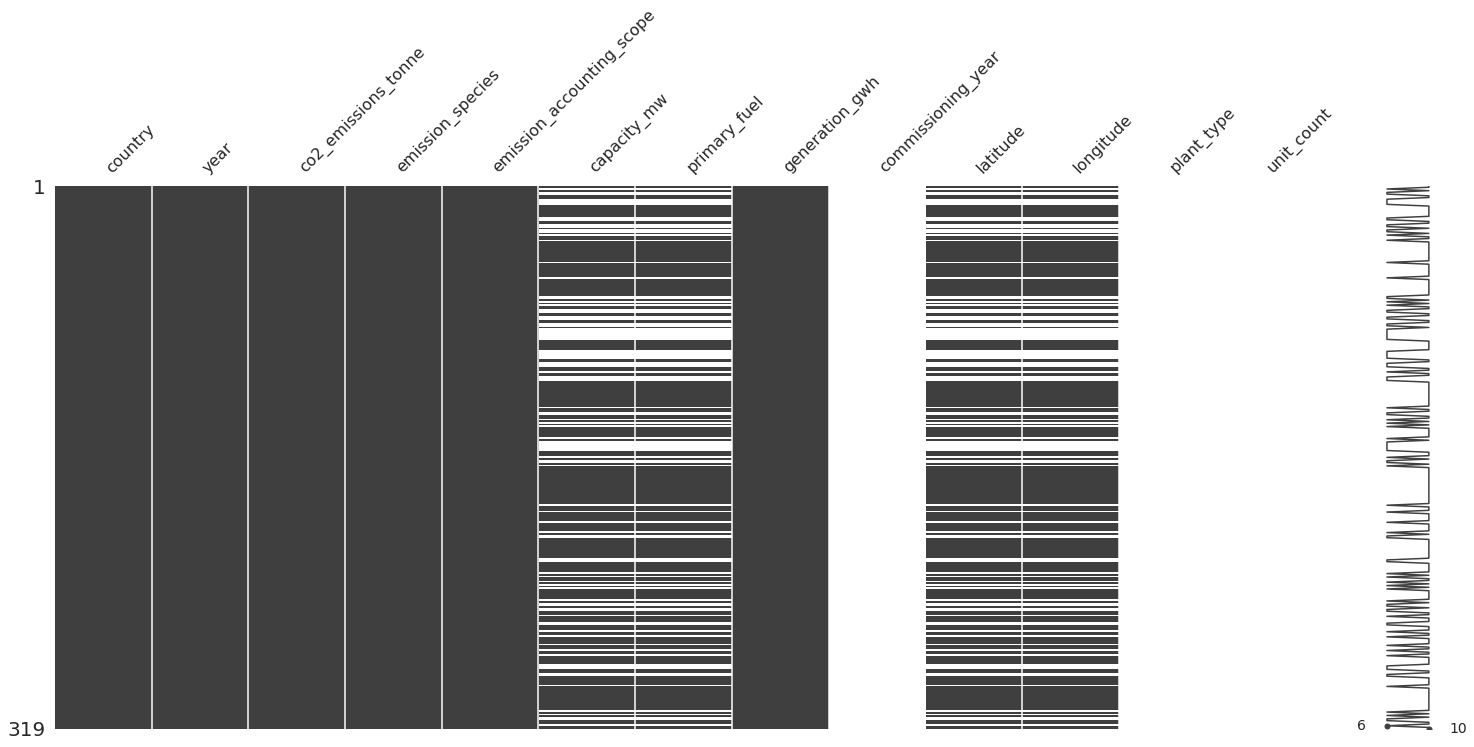

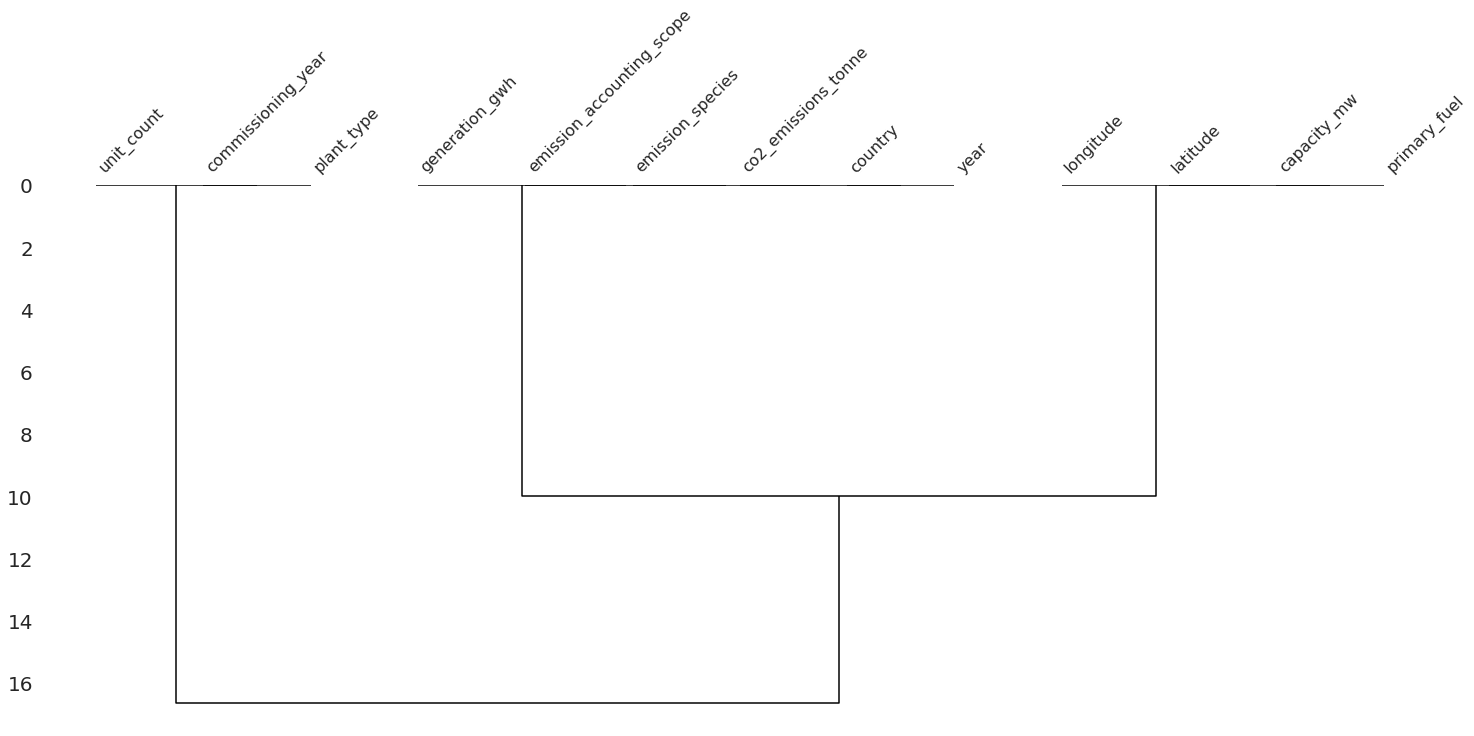

In [52]:
gp.nan_imp.missing_viz(path_aus_13)

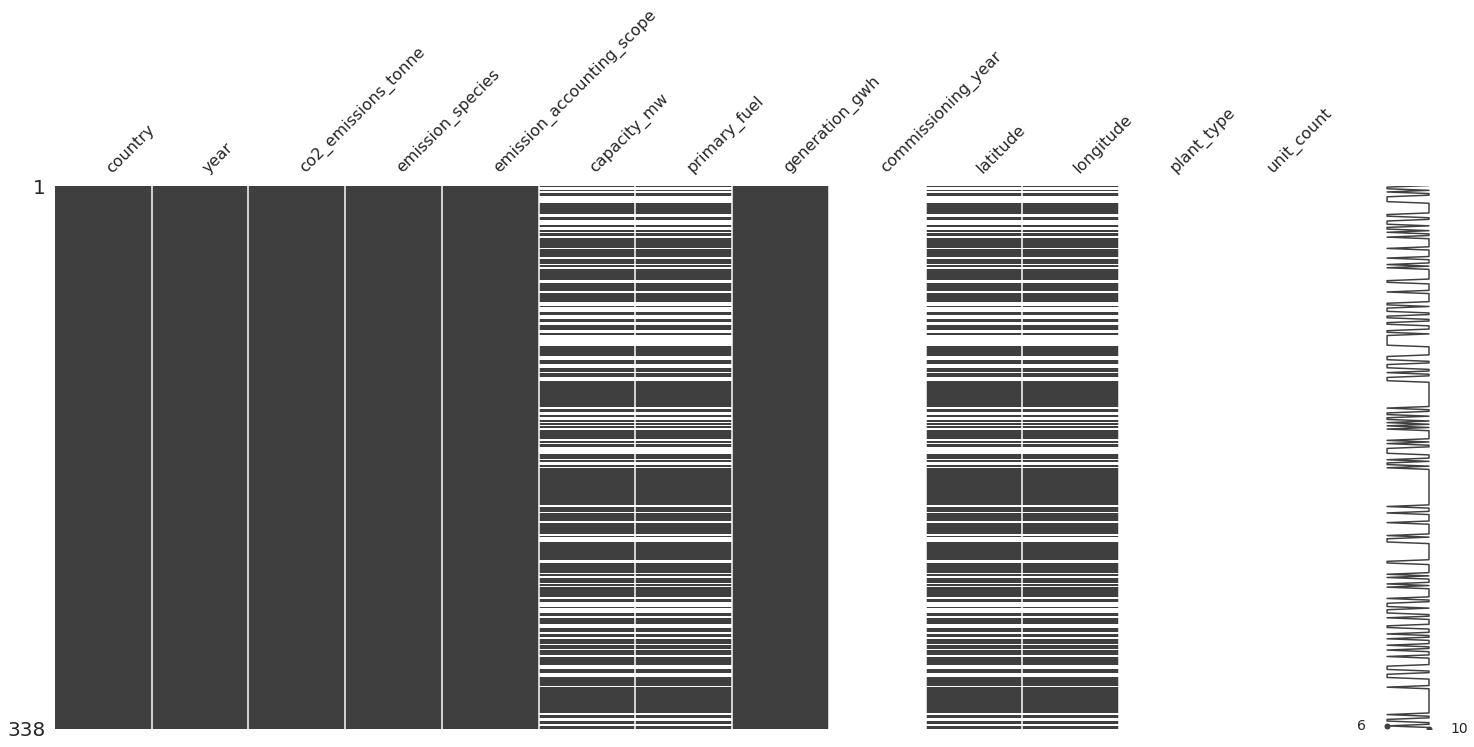

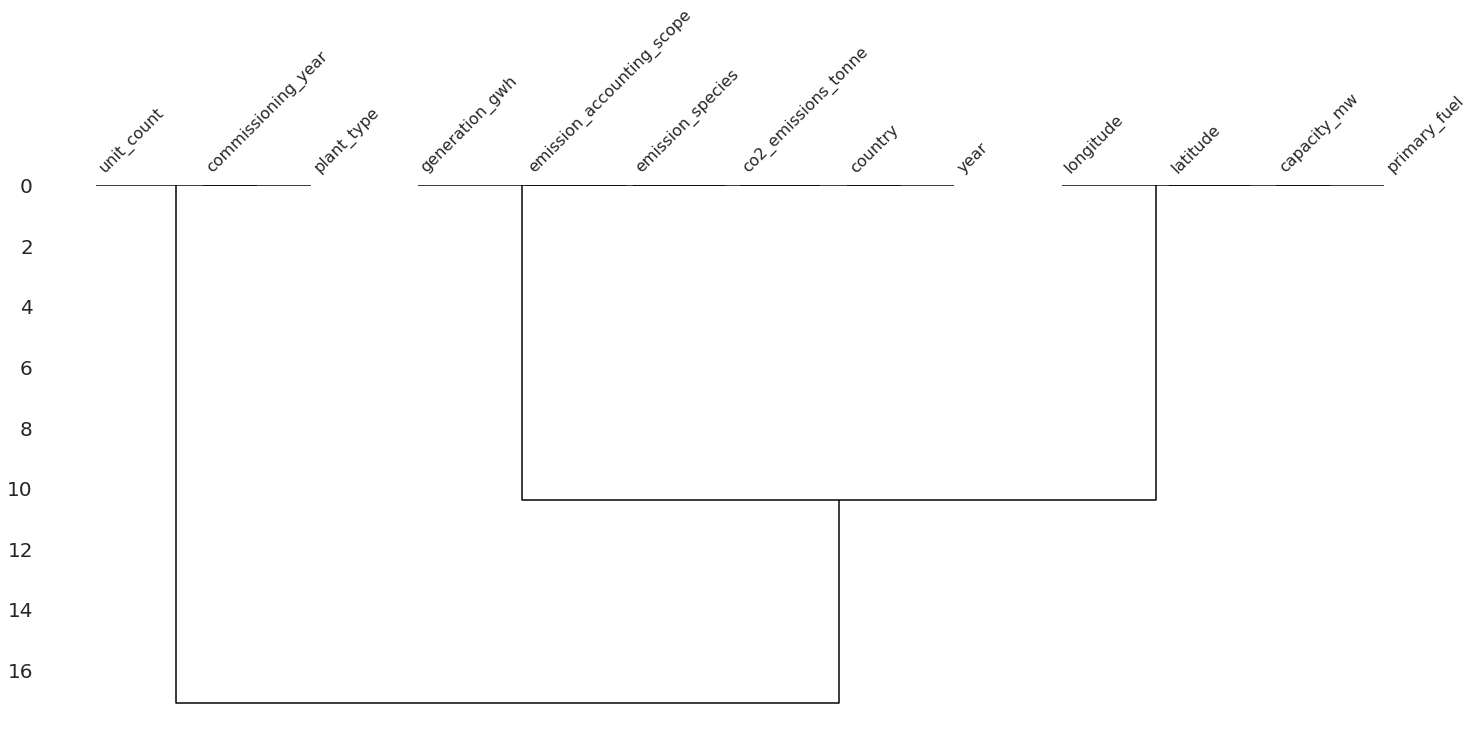

In [53]:
gp.nan_imp.missing_viz(path_aus_14)

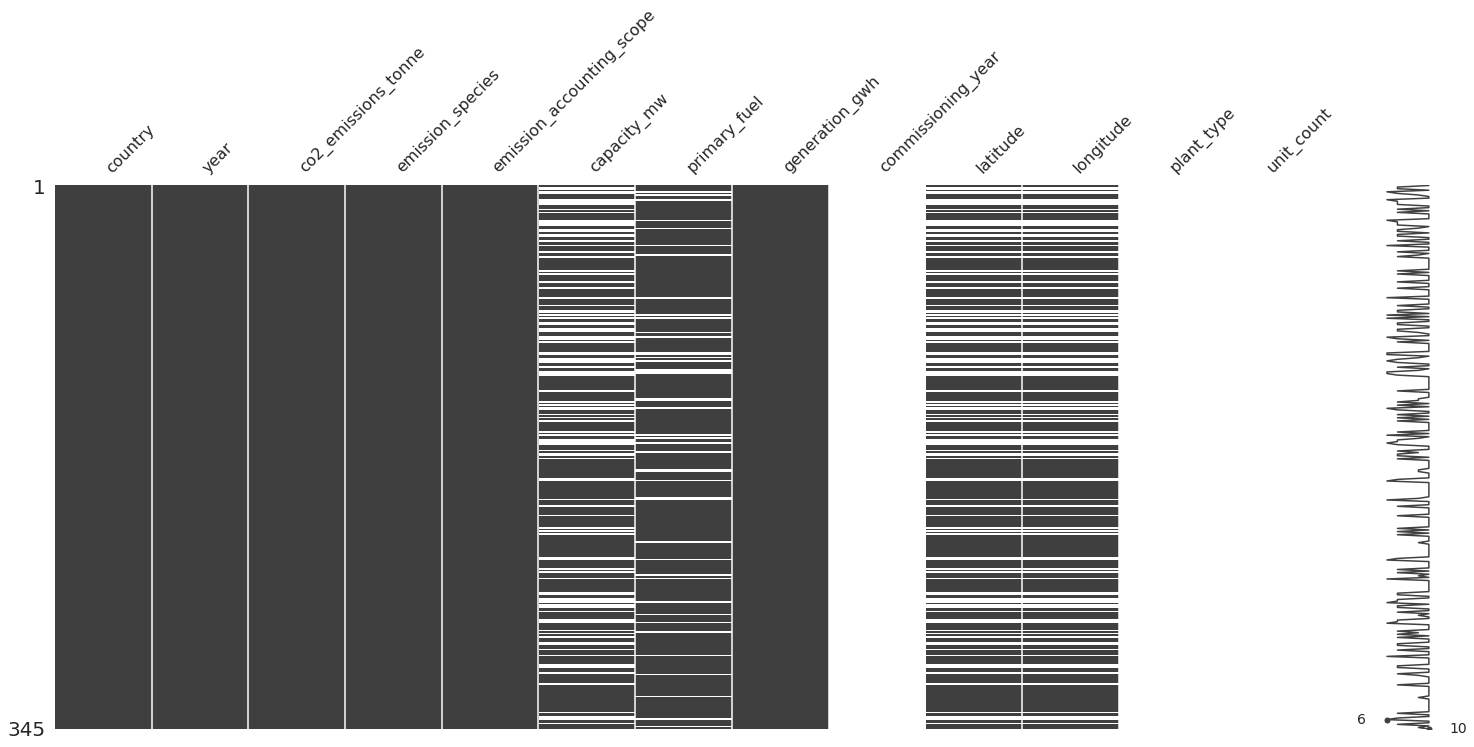

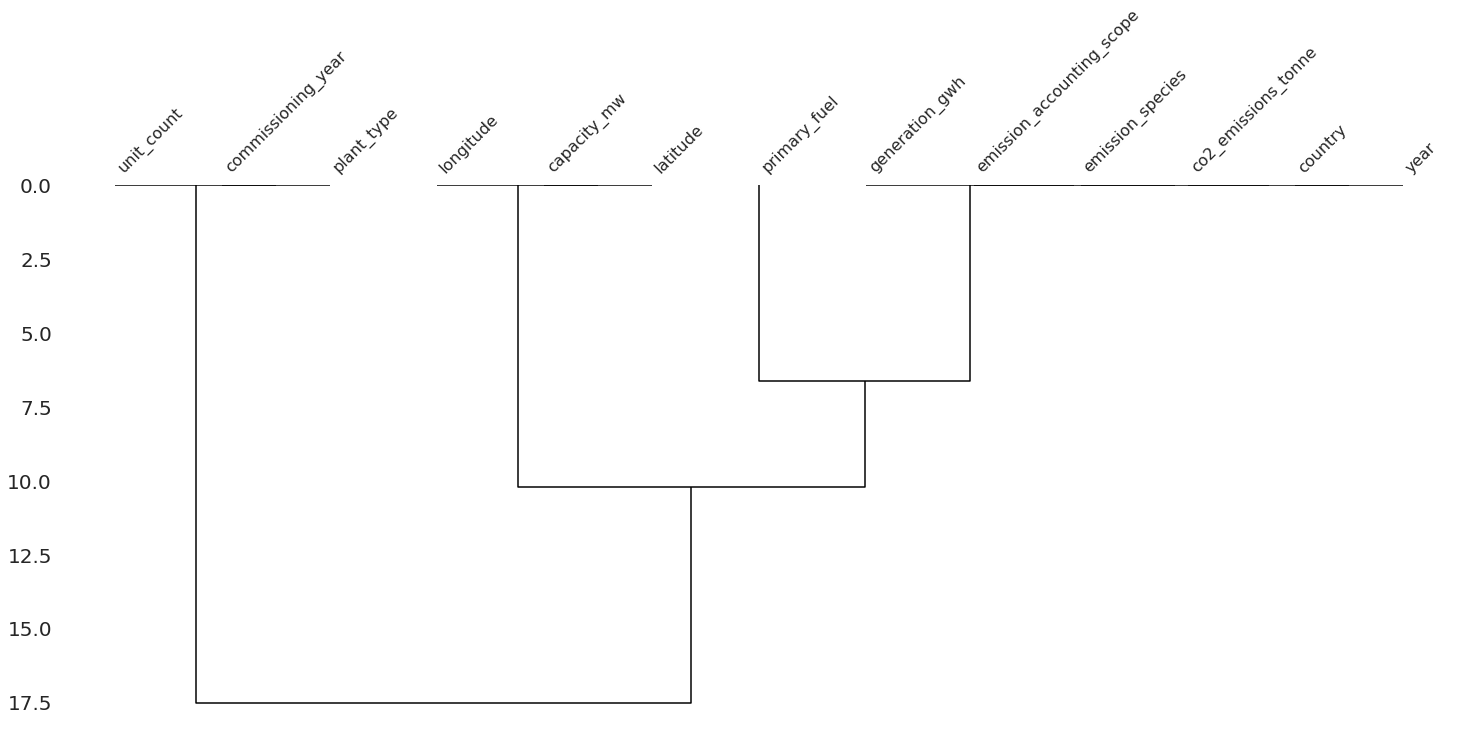

In [54]:
gp.nan_imp.missing_viz(path_aus_15)

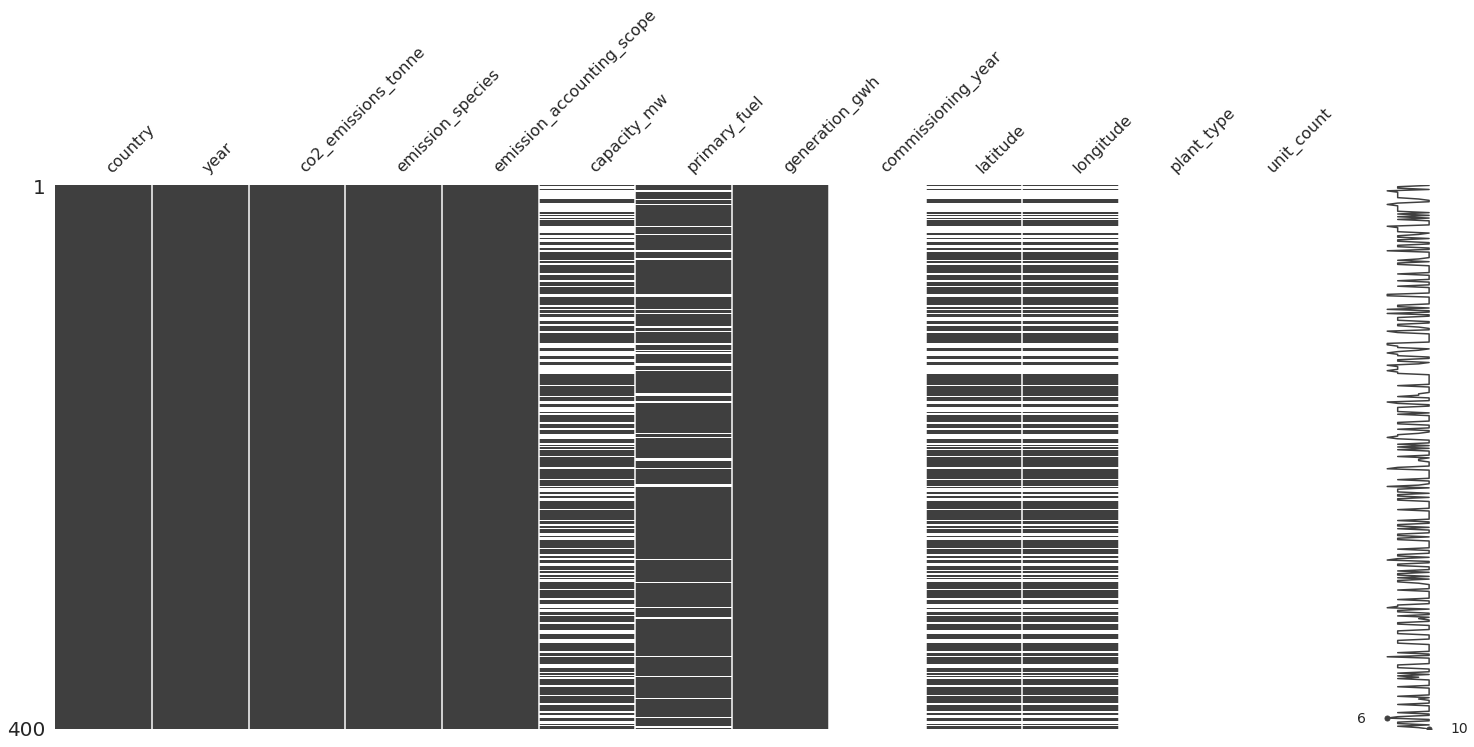

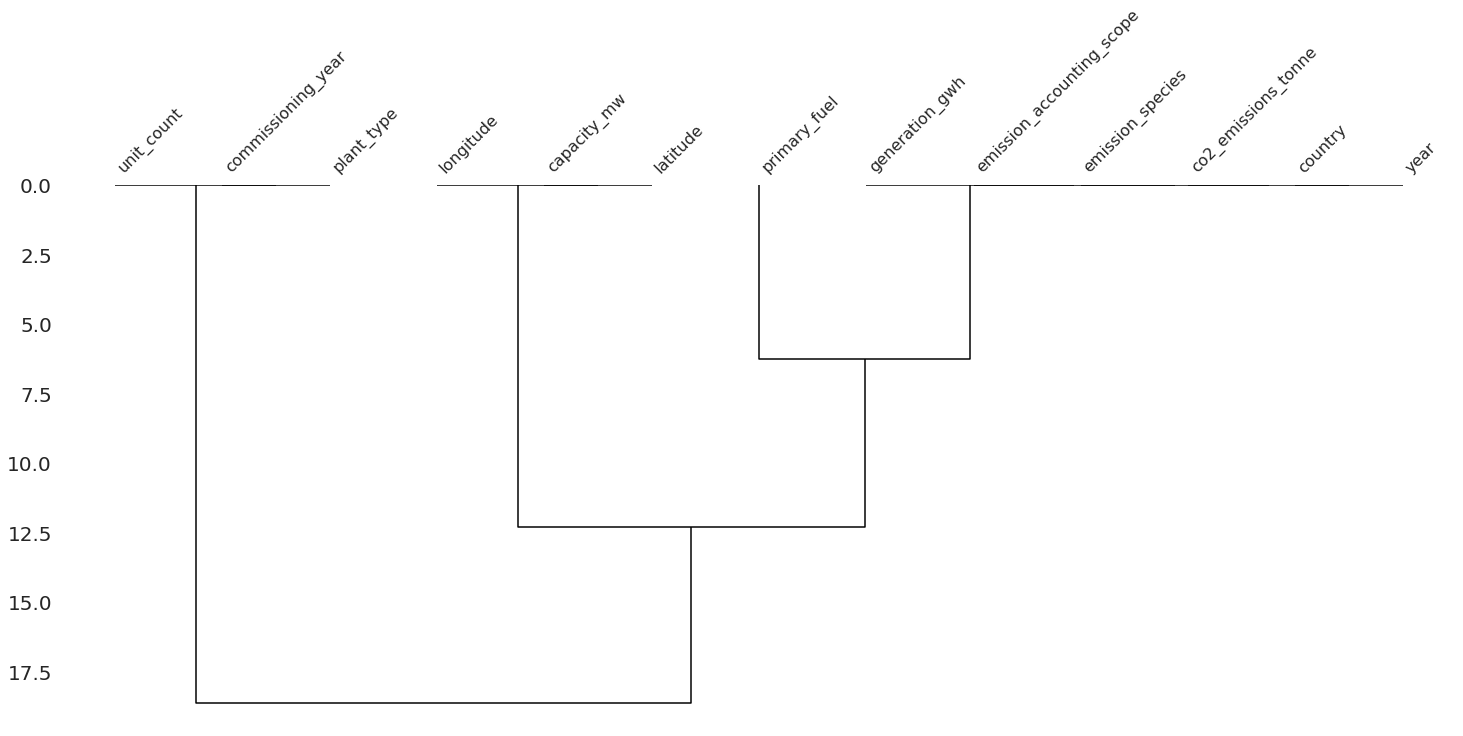

In [55]:
gp.nan_imp.missing_viz(path_aus_16)

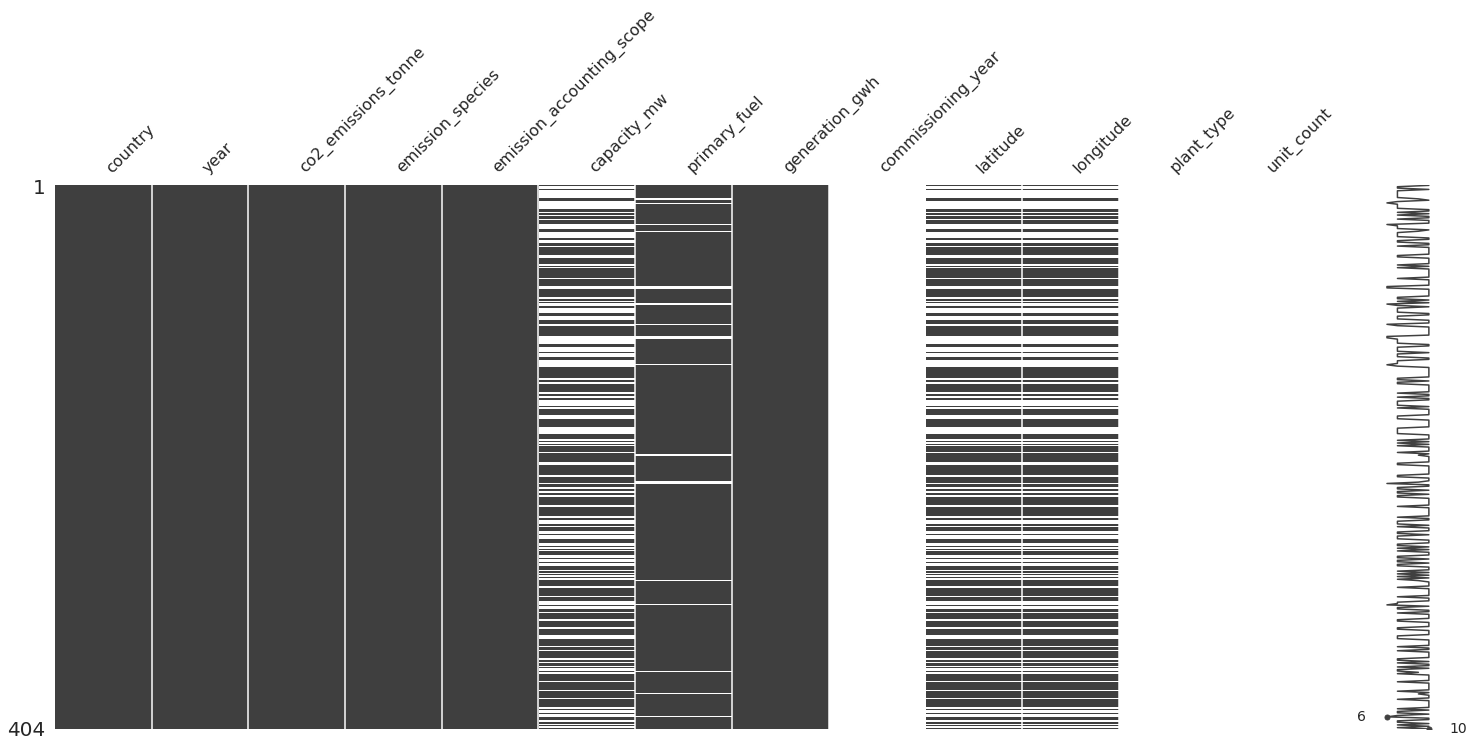

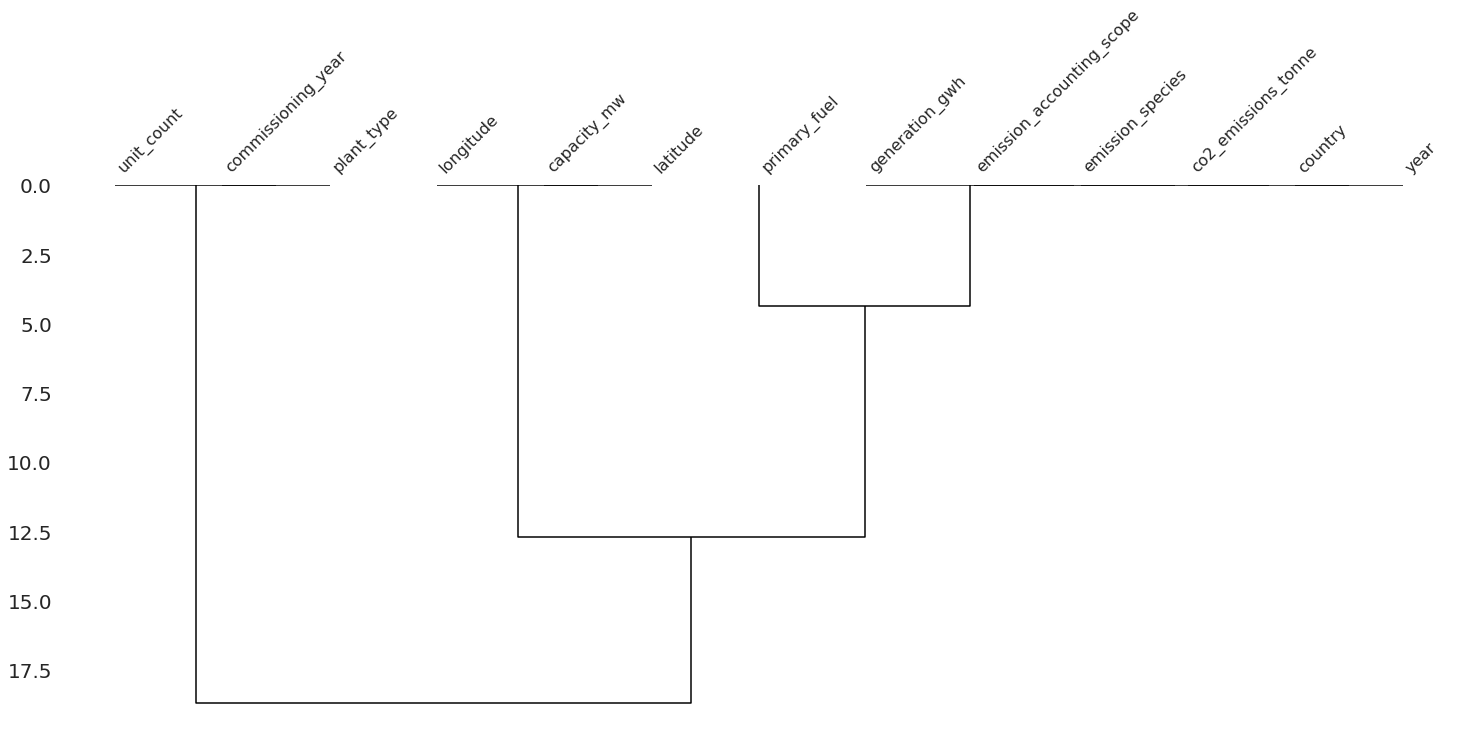

In [56]:
gp.nan_imp.missing_viz(path_aus_17)

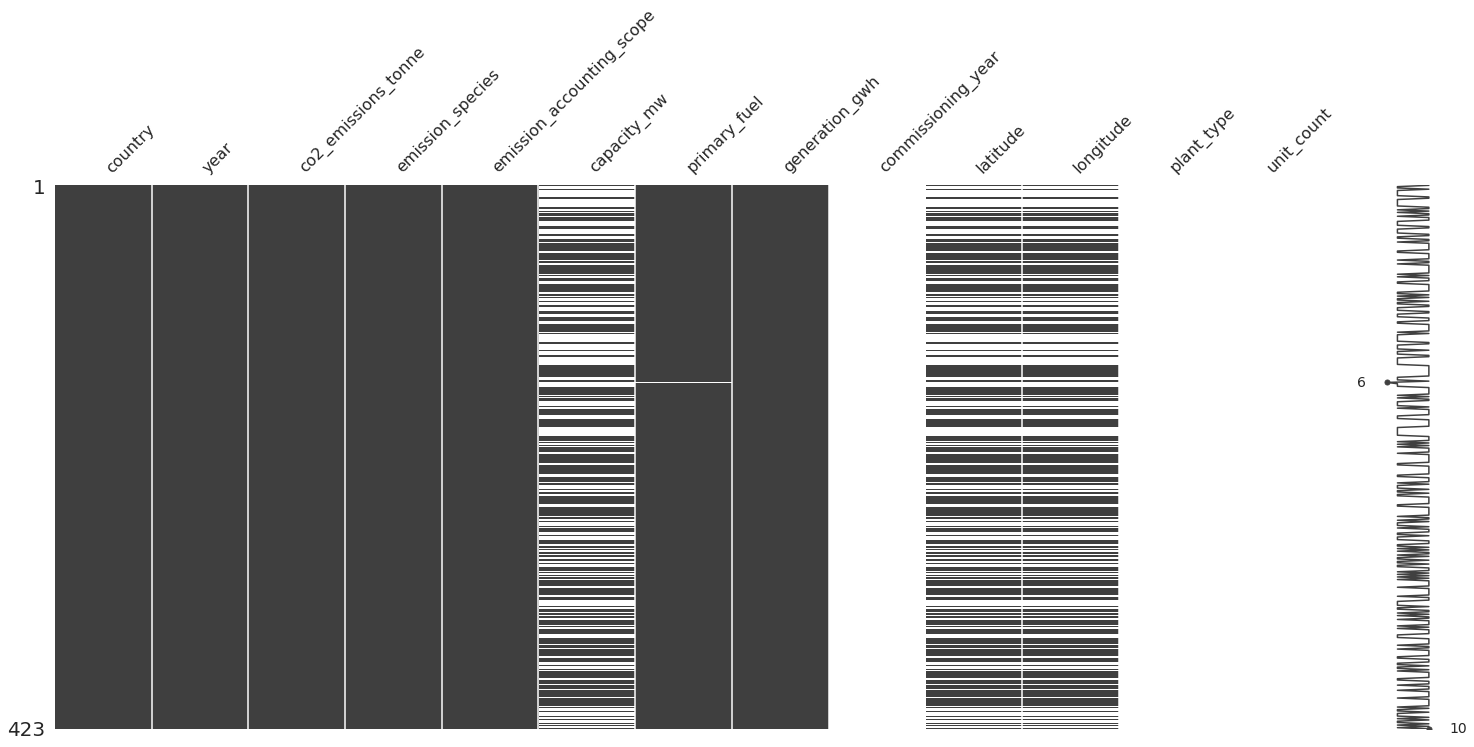

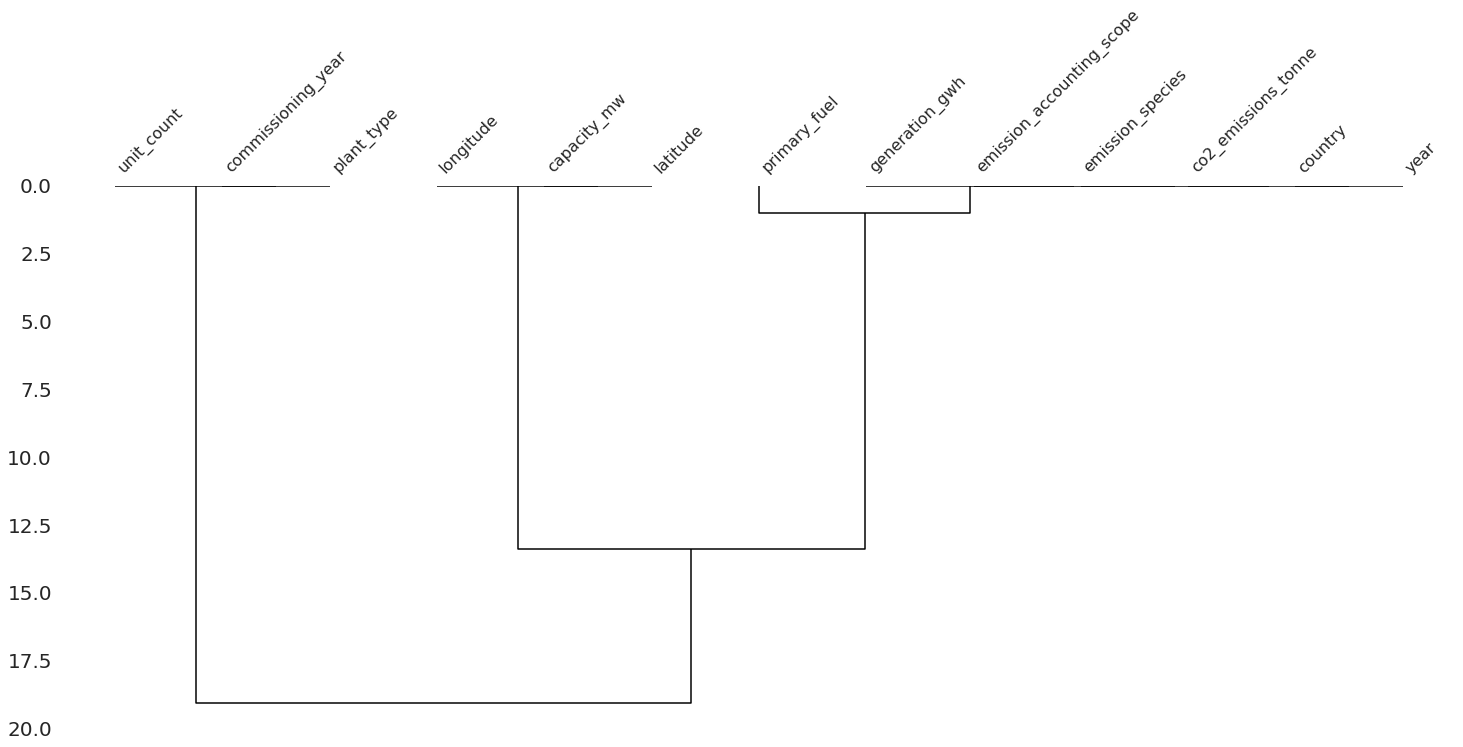

In [57]:
gp.nan_imp.missing_viz(path_aus_18)

country                        0
year                           0
co2_emissions_tonne            0
emission_species               0
emission_accounting_scope      0
capacity_mw                  100
primary_fuel                 100
generation_gwh                 0
commissioning_year           319
latitude                     100
longitude                    100
unit_count                   319
dtype: int64
[KNN] Estimated RF Test Error (n = 319, k = 1, 10-fold CV: -0.3877968024357695)
[KNN] Estimated RF Test Error (n = 319, k = 6, 10-fold CV: -1.280542873030741)
[KNN] Estimated RF Test Error (n = 319, k = 11, 10-fold CV: -1.2681997895006332)
[KNN] Estimated RF Test Error (n = 319, k = 16, 10-fold CV: -0.9295115818759248)
[KNN] Estimated RF Test Error (n = 319, k = 21, 10-fold CV: -0.933069410617674)
[KNN] Estimated RF Test Error (n = 319, k = 27, 10-fold CV: -0.9287199431398243)
[KNN] Estimated RF Test Error (n = 319, k = 32, 10-fold CV: -0.9459788046071569)
[KNN] Estimated RF Test Erro

,country,year,co2_emissions_tonne,emission_species,emission_accounting_scope,capacity_mw,primary_fuel,generation_gwh,commissioning_year,latitude,longitude,unit_count
0,3.0,2013.0,18868250.0,1.0,1.0,2180.000000,2.000000,16268.610833,0.0,-38.253600,146.574600,0.0
1,3.0,2013.0,10.0,1.0,1.0,21.600000,15.000000,89.595278,0.0,-35.064100,117.797700,0.0
2,3.0,2013.0,15310.0,1.0,1.0,20.877753,4.204498,10.294167,0.0,-25.245529,135.094016,0.0
3,3.0,2013.0,1175037.0,1.0,1.0,280.000000,4.000000,1354.565556,0.0,-32.647300,115.946900,0.0
4,3.0,2013.0,17539.0,1.0,1.0,9.183803,4.050475,30.608889,0.0,-22.122613,114.622182,0.0


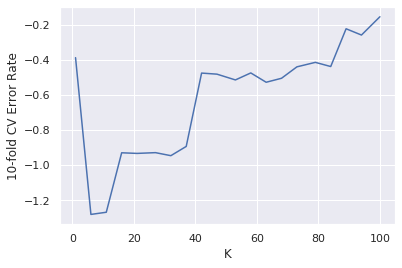

In [58]:
aus_13_fill=gp.nan_imp.knn_fill(path_aus_13)
aus_13_fill
aus_13_fill.head()

In [59]:
aus_13_fill.commissioning_year.replace({ 0.0:np.nan}, inplace=True)

country                        0
year                           0
co2_emissions_tonne            0
emission_species               0
emission_accounting_scope      0
capacity_mw                  108
primary_fuel                 108
generation_gwh                 0
commissioning_year           338
latitude                     108
longitude                    108
unit_count                   338
dtype: int64
[KNN] Estimated RF Test Error (n = 338, k = 1, 10-fold CV: -0.0905479679976232)
[KNN] Estimated RF Test Error (n = 338, k = 6, 10-fold CV: -0.20304543213449427)
[KNN] Estimated RF Test Error (n = 338, k = 11, 10-fold CV: -0.20210029490028028)
[KNN] Estimated RF Test Error (n = 338, k = 16, 10-fold CV: -0.19441207374778752)
[KNN] Estimated RF Test Error (n = 338, k = 21, 10-fold CV: -0.19535878308830074)
[KNN] Estimated RF Test Error (n = 338, k = 27, 10-fold CV: -0.1682230430090918)
[KNN] Estimated RF Test Error (n = 338, k = 32, 10-fold CV: 0.08294041378896647)
[KNN] Estimated RF Tes

,country,year,co2_emissions_tonne,emission_species,emission_accounting_scope,capacity_mw,primary_fuel,generation_gwh,commissioning_year,latitude,longitude,unit_count
0,3.0,2014.0,10.0,1.0,1.0,21.600000,15.000000,102.642778,0.0,-35.064100,117.797700,0.0
1,3.0,2014.0,103.0,1.0,1.0,23.534544,4.419214,3.688611,0.0,-29.321717,118.004239,0.0
2,3.0,2014.0,15103.0,1.0,1.0,106.635012,5.318874,16.485556,0.0,-24.412442,134.364461,0.0
3,3.0,2014.0,1131711.0,1.0,1.0,280.000000,4.000000,1277.396389,0.0,-32.647300,115.946900,0.0
4,3.0,2014.0,50.0,1.0,1.0,88.967198,11.559925,335.523333,0.0,-36.846540,142.589590,0.0


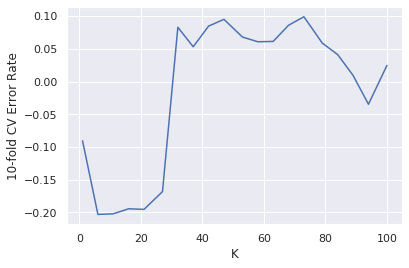

In [60]:
aus_14_fill=gp.nan_imp.knn_fill(path_aus_14)
aus_14_fill
aus_14_fill.head()

In [61]:
aus_14_fill.commissioning_year.replace({ 0.0:np.nan}, inplace=True)

country                        0
year                           0
co2_emissions_tonne            0
emission_species               0
emission_accounting_scope      0
capacity_mw                  105
primary_fuel                  44
generation_gwh                 0
commissioning_year           345
latitude                     105
longitude                    105
unit_count                   345
dtype: int64
[KNN] Estimated RF Test Error (n = 345, k = 1, 10-fold CV: 0.3061108769690768)
[KNN] Estimated RF Test Error (n = 345, k = 6, 10-fold CV: 0.2975358317799423)
[KNN] Estimated RF Test Error (n = 345, k = 11, 10-fold CV: 0.3271035289675998)
[KNN] Estimated RF Test Error (n = 345, k = 16, 10-fold CV: 0.3173106046841543)
[KNN] Estimated RF Test Error (n = 345, k = 21, 10-fold CV: 0.3259377229068661)
[KNN] Estimated RF Test Error (n = 345, k = 27, 10-fold CV: 0.3398453071517212)
[KNN] Estimated RF Test Error (n = 345, k = 32, 10-fold CV: 0.30953047333572903)
[KNN] Estimated RF Test Error (n

,country,year,co2_emissions_tonne,emission_species,emission_accounting_scope,capacity_mw,primary_fuel,generation_gwh,commissioning_year,latitude,longitude,unit_count
0,3.0,2015.0,13.0,1.0,1.0,21.600000,15.000000,96.555556,0.0,-35.064100,117.797700,0.0
1,3.0,2015.0,435.0,1.0,1.0,7.473785,13.000000,7.994167,0.0,-41.405488,147.445079,0.0
2,3.0,2015.0,13869.0,1.0,1.0,38.371000,4.000000,15.619167,0.0,-23.402599,134.559473,0.0
3,3.0,2015.0,1301720.0,1.0,1.0,280.000000,4.000000,1639.092222,0.0,-32.647300,115.946900,0.0
4,3.0,2015.0,111432.0,1.0,1.0,46.240503,7.500215,176.957778,0.0,-23.333617,120.490045,0.0


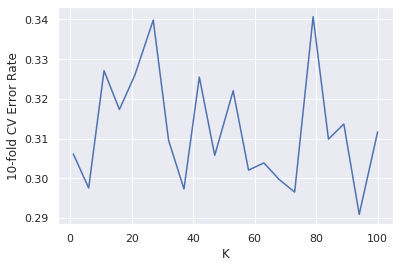

In [62]:
aus_15_fill=gp.nan_imp.knn_fill(path_aus_15)
aus_15_fill
aus_15_fill.head()

In [63]:
aus_15_fill.commissioning_year.replace({ 0.0:np.nan}, inplace=True)

country                        0
year                           0
co2_emissions_tonne            0
emission_species               0
emission_accounting_scope      0
capacity_mw                  152
primary_fuel                  39
generation_gwh                 0
commissioning_year           400
latitude                     152
longitude                    152
unit_count                   400
dtype: int64
[KNN] Estimated RF Test Error (n = 400, k = 1, 10-fold CV: -1.3989724200791764)
[KNN] Estimated RF Test Error (n = 400, k = 6, 10-fold CV: -1.4617496012757916)
[KNN] Estimated RF Test Error (n = 400, k = 11, 10-fold CV: -1.5050049548873983)
[KNN] Estimated RF Test Error (n = 400, k = 16, 10-fold CV: -1.4080706074135239)
[KNN] Estimated RF Test Error (n = 400, k = 21, 10-fold CV: -1.4036737719671941)
[KNN] Estimated RF Test Error (n = 400, k = 27, 10-fold CV: -1.3704659945446356)
[KNN] Estimated RF Test Error (n = 400, k = 32, 10-fold CV: -1.246077981866517)
[KNN] Estimated RF Test Err

,country,year,co2_emissions_tonne,emission_species,emission_accounting_scope,capacity_mw,primary_fuel,generation_gwh,commissioning_year,latitude,longitude,unit_count
0,3.0,2016.0,12.0,1.0,1.0,21.600000,15.000000,95.872778,0.0,-35.064100,117.797700,0.0
1,3.0,2016.0,425.0,1.0,1.0,2.284952,13.000000,7.645556,0.0,-37.347107,145.084616,0.0
2,3.0,2016.0,13568.0,1.0,1.0,76.597915,4.000000,14.397500,0.0,-31.190219,129.521824,0.0
3,3.0,2016.0,1401162.0,1.0,1.0,280.000000,4.000000,2057.255833,0.0,-32.647300,115.946900,0.0
4,3.0,2016.0,142586.0,1.0,1.0,98.056331,4.116713,223.859722,0.0,-28.399670,135.520464,0.0


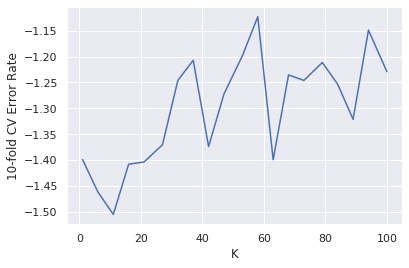

In [64]:
aus_16_fill=gp.nan_imp.knn_fill(path_aus_16)
aus_16_fill
aus_16_fill.head()

In [65]:
aus_16_fill.commissioning_year.replace({ 0.0:np.nan}, inplace=True)

country                        0
year                           0
co2_emissions_tonne            0
emission_species               0
emission_accounting_scope      0
capacity_mw                  162
primary_fuel                  19
generation_gwh                 0
commissioning_year           404
latitude                     162
longitude                    162
unit_count                   404
dtype: int64
[KNN] Estimated RF Test Error (n = 404, k = 1, 10-fold CV: -5.237731957840157)
[KNN] Estimated RF Test Error (n = 404, k = 6, 10-fold CV: -4.933425067879869)
[KNN] Estimated RF Test Error (n = 404, k = 11, 10-fold CV: -4.916589982843076)
[KNN] Estimated RF Test Error (n = 404, k = 16, 10-fold CV: -4.938040454293633)
[KNN] Estimated RF Test Error (n = 404, k = 21, 10-fold CV: -5.008456000617926)
[KNN] Estimated RF Test Error (n = 404, k = 27, 10-fold CV: -5.0442580443243275)
[KNN] Estimated RF Test Error (n = 404, k = 32, 10-fold CV: -5.0391624692026635)
[KNN] Estimated RF Test Error (

,country,year,co2_emissions_tonne,emission_species,emission_accounting_scope,capacity_mw,primary_fuel,generation_gwh,commissioning_year,latitude,longitude,unit_count
0,3.0,2017.0,12.0,1.0,1.0,21.600000,15.0,85.900278,0.0,-35.064100,117.797700,0.0
1,3.0,2017.0,467.0,1.0,1.0,5.833840,13.0,8.580833,0.0,-37.422996,143.176847,0.0
2,3.0,2017.0,13692.0,1.0,1.0,29.343481,4.0,14.028333,0.0,-26.218666,132.171007,0.0
3,3.0,2017.0,1509401.0,1.0,1.0,280.000000,4.0,2271.889167,0.0,-32.647300,115.946900,0.0
4,3.0,2017.0,90740.0,1.0,1.0,187.424621,4.0,139.461944,0.0,-28.937488,146.201721,0.0


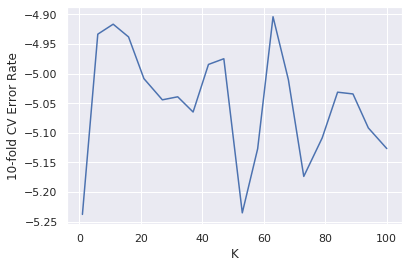

In [66]:
aus_17_fill=gp.nan_imp.knn_fill(path_aus_17)
aus_17_fill
aus_17_fill.head()

In [67]:
aus_17_fill.commissioning_year.replace({ 0.0:np.nan}, inplace=True)

In [ ]:
aus_18_fill=gp.nan_imp.knn_fill(path_aus_18)
aus_18_fill
aus_18_fill.head()

country                        0
year                           0
co2_emissions_tonne            0
emission_species               0
emission_accounting_scope      0
capacity_mw                  179
primary_fuel                   1
generation_gwh                 0
commissioning_year           423
latitude                     179
longitude                    179
unit_count                   423
dtype: int64
[KNN] Estimated RF Test Error (n = 423, k = 1, 10-fold CV: -4.182268277183959)
[KNN] Estimated RF Test Error (n = 423, k = 6, 10-fold CV: -3.342294615881827)
[KNN] Estimated RF Test Error (n = 423, k = 11, 10-fold CV: -3.3032501716346347)
[KNN] Estimated RF Test Error (n = 423, k = 16, 10-fold CV: -3.5835735624157805)
[KNN] Estimated RF Test Error (n = 423, k = 21, 10-fold CV: -3.4366686448557124)
[KNN] Estimated RF Test Error (n = 423, k = 27, 10-fold CV: -3.6245412202477256)
[KNN] Estimated RF Test Error (n = 423, k = 32, 10-fold CV: -3.35603796050822)
[KNN] Estimated RF Test Error 

In [ ]:
aus_18_fill.commissioning_year.replace({ 0.0:np.nan}, inplace=True)

## Saving training_filled CSV file

In [ ]:
aus_13_fill.to_csv('../public/training_filled/training_filled_australia_2012-13.csv', index=False)

In [ ]:
aus_14_fill.to_csv('../public/training_filled/training_filled_australia_2013-14.csv', index=False)

In [ ]:
aus_15_fill.to_csv('../public/training_filled/training_filled_australia_2014-15.csv', index=False)

In [ ]:
aus_16_fill.to_csv('../public/training_filled/training_filled_australia_2015-16.csv', index=False)

In [ ]:
aus_17_fill.to_csv('../public/training_filled/training_filled_australia_2016-17.csv', index=False)

In [ ]:
aus_18_fill.to_csv('../public/training_filled/training_filled_australia_2017-18.csv', index=False)